In [1]:
# Imports
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

from lib.utility_functions import *
from lib.exp4 import *

# Config
sns.set_style('white')
sns.set_context('talk')

colors = sns.color_palette().as_hex()

pd.set_option('display.max_columns', 40)

% matplotlib inline

/Users/gianni/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
tidy = pd.read_csv('./tidy_data.csv', index_col=0)

In [3]:
tidy.head()

,Subject ID,Condition,Game Index,Position ID,Is Real,Black Position,White Position,Black Position (final),White Position (final),Response Time,Num Black Pieces,Num White Pieces,Num Pieces,Total Black Errors,Total White Errors,Total Errors,Type I Errors (black),Type I Errors (white),Type I Errors,Type II Errors (black),Type II Errors (white),Type II Errors,Type III Errors (black),Type III Errors (white),Type III Errors,Num Pieces (final),Numerosity Error
0,1464109333721,Trained,0,25.0,False,000000000011010000010100000001010001,001100000000001000001000000010100010,000000000011010000010100100001000000,000100000000100010001011000000000100,43.957,8,7,15,3,10,13.0,1,5,6,2,5,7,0,0,0,14,1
2,1464109333721,Trained,1,92.0,True,001011000000011000000101000000010100,000100000001100100000010100001101000,000001000001011000000101000000010100,000100000000100100001010100000101000,36.897,9,9,18,3,3,5.0,0,1,1,2,1,3,0,1,1,16,2
4,1464109333721,Trained,2,16.0,False,100100000001010000000100000000101000,000010000010000100001001000001000000,100100000001010000000101000000100000,000001000010000100001000000000000000,17.922,7,6,13,2,4,5.0,0,1,1,1,2,3,0,1,1,11,2
6,1464109333721,Trained,3,75.0,True,000001001000101100001001000000010000,000100000001010000010110000000001000,000001001001001100000101000000010000,000100000000110000000010000000001000,22.380,8,7,15,4,4,5.0,0,0,0,1,1,2,1,2,3,13,2
8,1464109333721,Trained,4,69.0,True,000101000101100000001100000000000000,000000000010011000000001000000111000,000101000101100000001100000000000000,000000000010011000000001000000111000,20.494,7,7,14,0,0,0.0,0,0,0,0,0,0,0,0,0,14,0


In [4]:
tidy['Num Dif'] = tidy['Num Pieces'] - tidy['Num Pieces (final)']

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/legend.py:652: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


Real positions p: 0.3411 val: -0.5307017543859649
Fake positions p: 0.3878 val: -0.5394736842105248


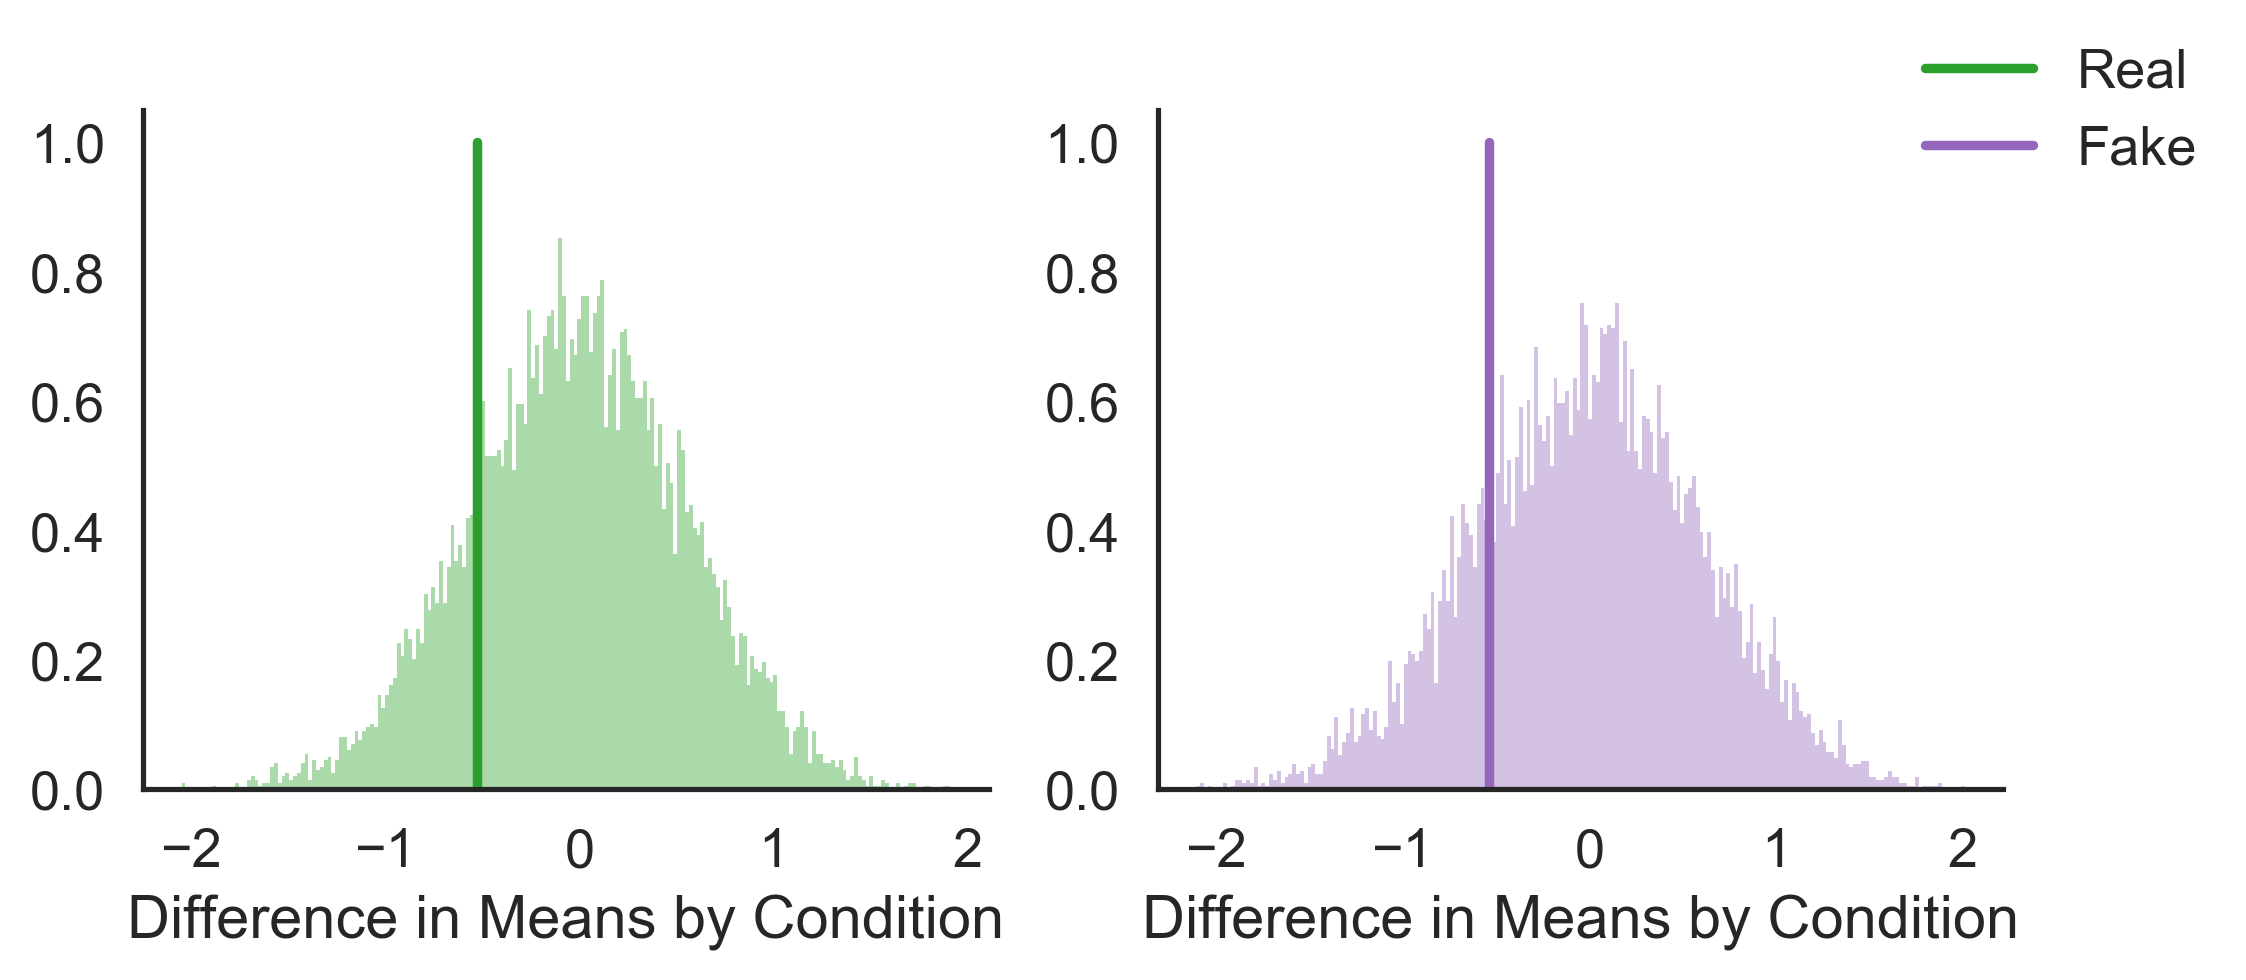

In [9]:
def between_permutation_test(target_var, num_resamples=10000):
    piv = tidy.pivot_table(
        index='Subject ID', values=target_var,
        columns='Is Real',
        aggfunc=np.mean
    )
    
    piv['Condition'] = piv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])
    
    condition_filter = piv['Condition'] == 'Trained'
    
    true_real_dif = piv.loc[condition_filter, True].mean() - piv.loc[~condition_filter, True].mean()
    true_fake_dif = piv.loc[condition_filter, False].mean() - piv.loc[~condition_filter, False].mean()
    
    samples = {'real': [], 'fake': []}
    
    for i in range(num_resamples):
        piv['Resampled Condition'] = piv['Condition'].sample(frac=1, replace=False).values
        resample_filter = piv['Resampled Condition'] == 'Trained'
        
        real_dif = piv.loc[resample_filter, True].mean() - piv.loc[~resample_filter, True].mean()
        fake_dif = piv.loc[resample_filter, False].mean() - piv.loc[~resample_filter, False].mean()
    
        samples['real'].append(real_dif)
        samples['fake'].append(fake_dif)
        
    # Continue
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
    
    sns.distplot(samples['real'], bins=200, color=colors[2], kde=False, norm_hist=True, ax=axes[0])
    sns.distplot(samples['fake'], bins=200, color=colors[4], kde=False, norm_hist=True, ax=axes[1])

    axes[0].plot([true_real_dif, ]*2, [0, 1], color=colors[2], label='Real')
    axes[1].plot([true_fake_dif, ]*2, [0, 1], color=colors[4], label='Fake')

    plt.figlegend(loc=0)
    plt.setp(axes, xlabel='Difference in Means by Condition')

    sns.despine()
    
    real = np.stack(samples['real'])
    real_index = (real >= np.abs(true_real_dif))
    real_index |= (real <= -np.abs(true_real_dif))

    print('Real positions p:', len(real[real_index]) / len(real), 'val:', true_real_dif)

    fake = np.stack(samples['fake'])
    fake_index = (fake >= np.abs(true_fake_dif))
    fake_index |= (fake <= -np.abs(true_fake_dif))

    print('Fake positions p:', len(fake[fake_index]) / len(fake), 'val:', true_fake_dif)
    
    return samples, axes

samples, axes = between_permutation_test('Total Errors')

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/legend.py:652: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


Real positions p: 0.3487 val: -0.4002192982456141
Fake positions p: 0.1817 val: -0.6929824561403501


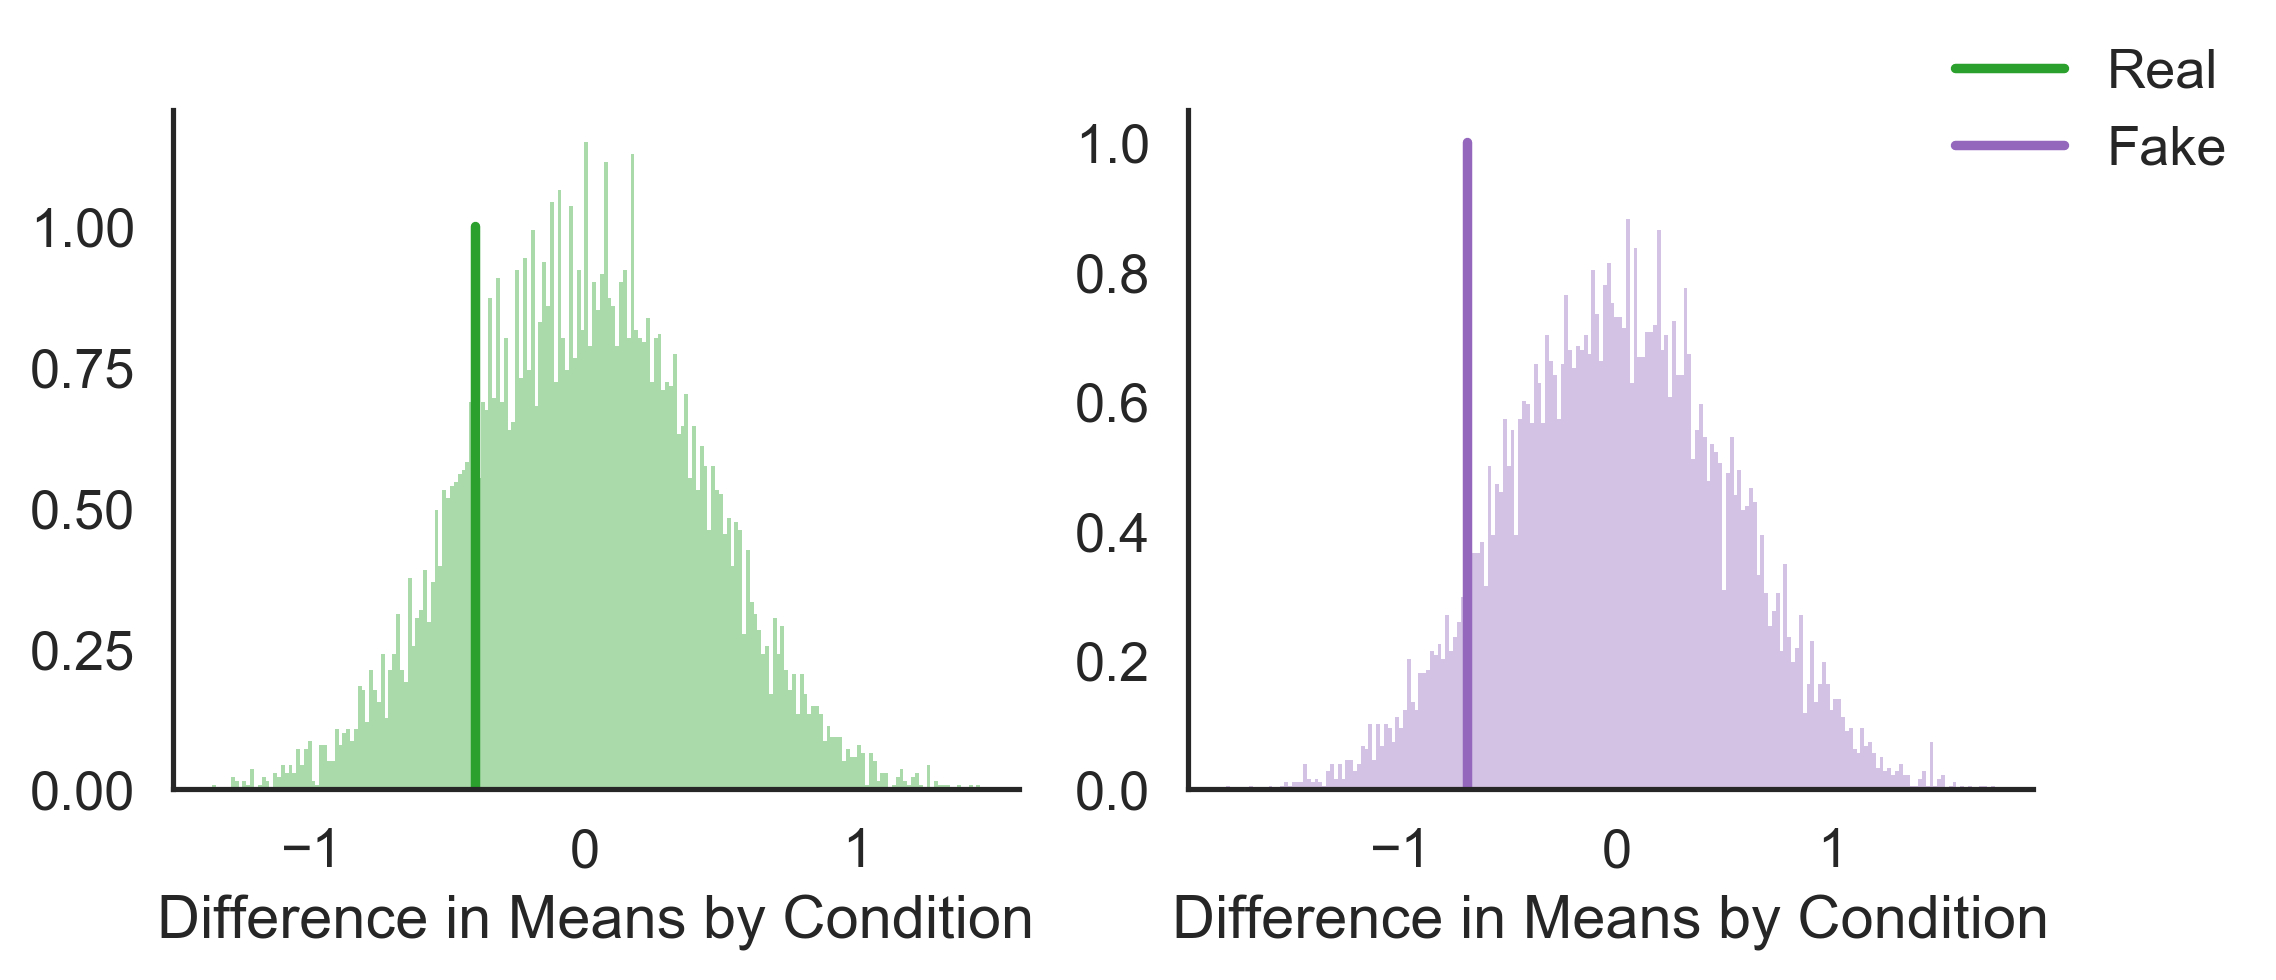

In [10]:
samples, axes = between_permutation_test('Num Dif')

In [11]:
def within_permutation_test(target_var, num_resamples=10000):
    
    g = tidy.groupby('Subject ID', sort=False)
    
    def get_piv():
        piv = tidy.pivot_table(
            index='Subject ID', values=target_var,
            columns='Resampled Is Real',
            aggfunc=np.mean
        )

        piv['Condition'] = piv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])
        
        return piv
    
    def resample_from_groups(df):
        return df[['Is Real', 'Subject ID']].sample(frac=1, replace=False)
        
    def shuffle_real():
        applied = g.apply(resample_from_groups)
        applied = pd.DataFrame(applied)
        melted = pd.melt(applied, id_vars=['Subject ID'], value_vars=['Is Real'], value_name='Is Real')
        
        return melted['Is Real'].values
    
    piv = tidy.pivot_table(
        index='Subject ID', values=target_var,
        columns='Is Real',
        aggfunc=np.mean
    )

    piv['Condition'] = piv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])

    condition_filter = piv['Condition'] == 'Trained'
    
    true_trained_dif = piv.loc[condition_filter, True].mean() - piv.loc[condition_filter, False].mean()
    true_untrained_dif = piv.loc[~condition_filter, True].mean() - piv.loc[~condition_filter, False].mean()
    
    samples = {'trained': [], 'untrained': []}
    
    for i in range(num_resamples):
        tidy['Resampled Is Real'] = shuffle_real()
        
        piv = get_piv()
        
        condition_filter = piv['Condition'] == 'Trained'
        
        trained_dif = piv.loc[condition_filter, True].mean() - piv.loc[condition_filter, False].mean()
        untrained_dif = piv.loc[~condition_filter, True].mean() - piv.loc[~condition_filter, False].mean()
    
        samples['trained'].append(trained_dif)
        samples['untrained'].append(untrained_dif)
        
    # Break out plotting and prints to separate function
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
    
    sns.distplot(samples['trained'], bins=200, color=colors[0], kde=False, norm_hist=True, ax=axes[0])
    sns.distplot(samples['untrained'], bins=200, color=colors[1], kde=False, norm_hist=True, ax=axes[1])

    axes[0].plot([true_trained_dif, ]*2, [0, 3], color=colors[0], label='Trained')
    axes[1].plot([true_untrained_dif, ]*2, [0, 3], color=colors[1], label='Untrained')

    plt.figlegend(loc=0)
    plt.setp(axes, xlabel='Difference in Means by Position Type')

    sns.despine()
    
    trained = np.stack(samples['trained'])
    trained_index = (trained >= np.abs(true_trained_dif))
    trained_index |= (trained <= -np.abs(true_trained_dif))

    print('Trained subjects p:', len(trained[trained_index]) / len(trained), 'val:', true_trained_dif)

    untrained = np.stack(samples['untrained'])
    untrained_index = (untrained >= np.abs(true_untrained_dif))
    untrained_index |= (untrained <= -np.abs(true_untrained_dif))

    print('Untrained subjects p:', len(untrained[untrained_index]) / len(untrained), 'val:', true_untrained_dif)
    
    return samples, axes

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/legend.py:652: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


Trained subjects p: 0.0 val: -2.1041666666666687
Untrained subjects p: 0.0 val: -2.1129385964912286


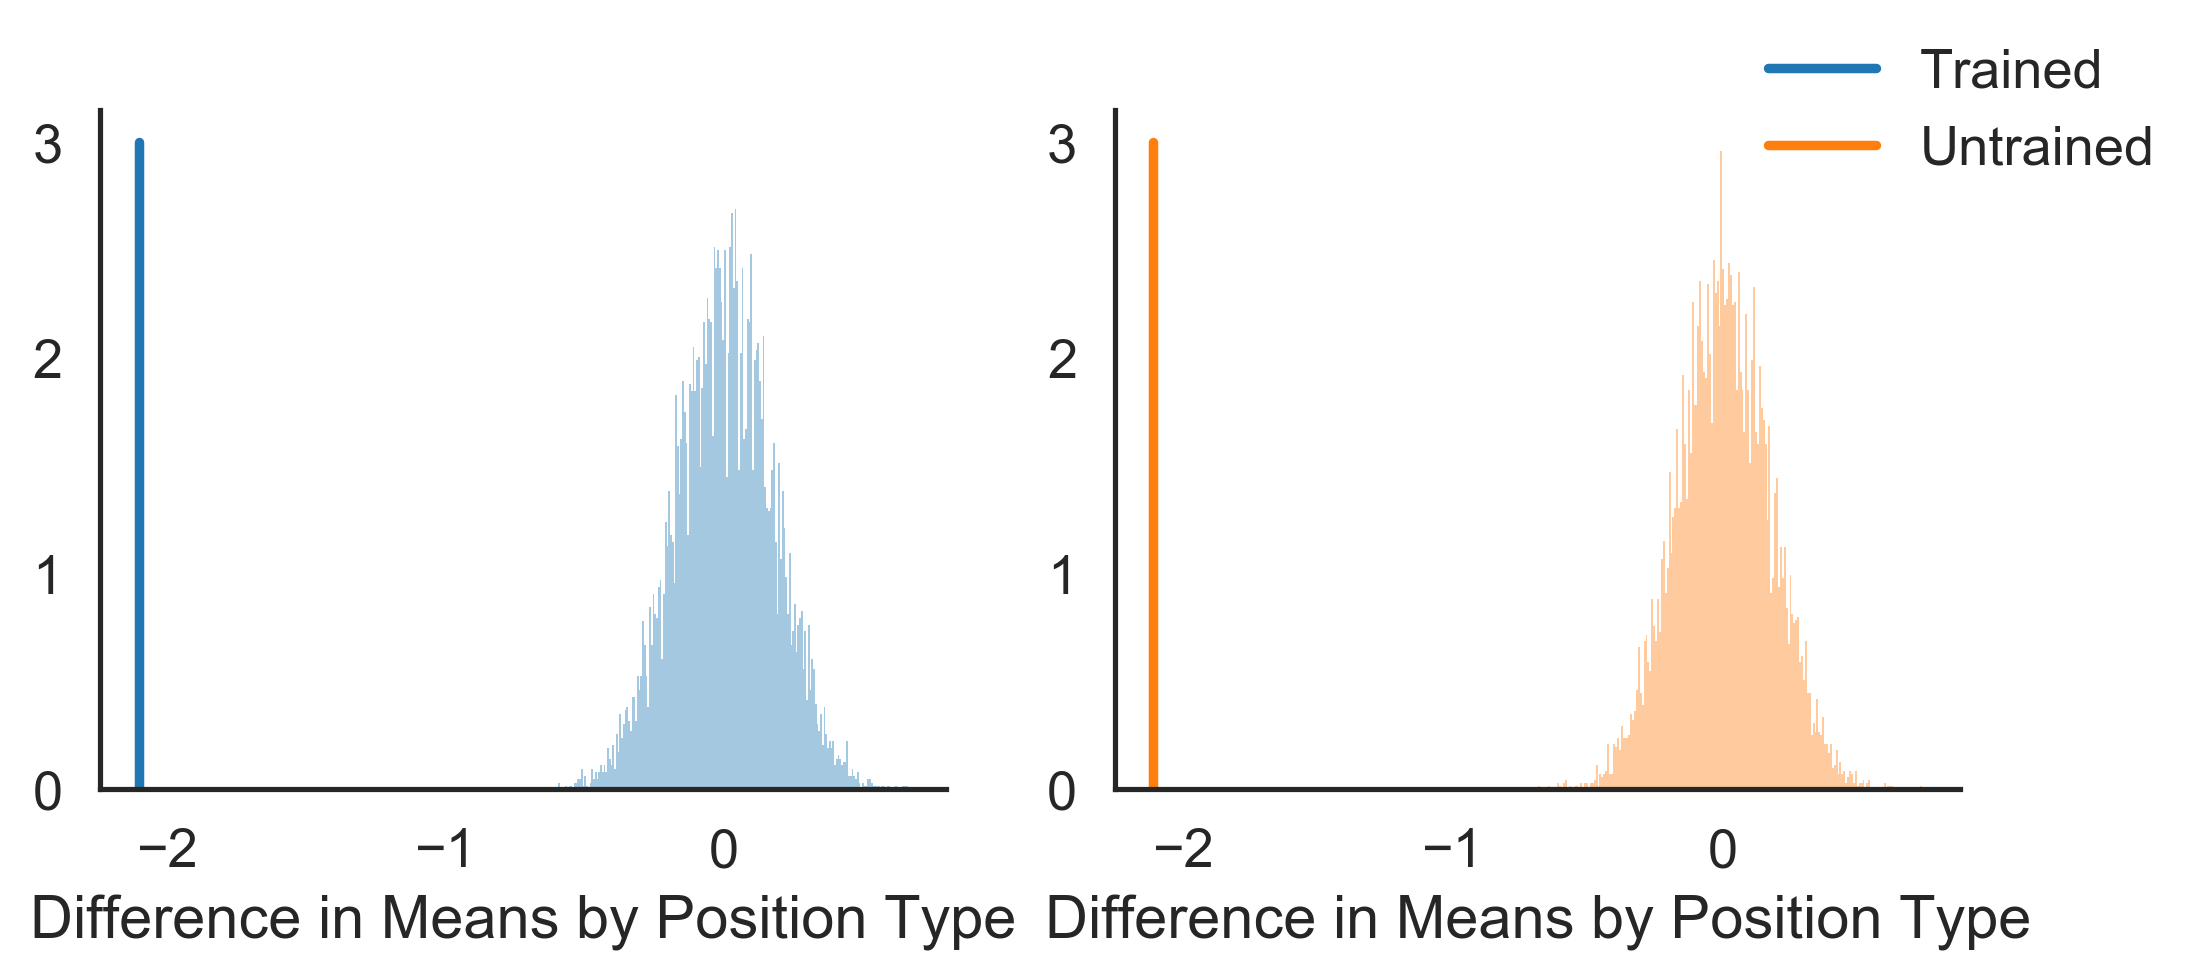

In [12]:
samples, axes = within_permutation_test('Total Errors')

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/legend.py:652: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


Trained subjects p: 0.0 val: -0.45614035087719285
Untrained subjects p: 0.0 val: -0.7489035087719289


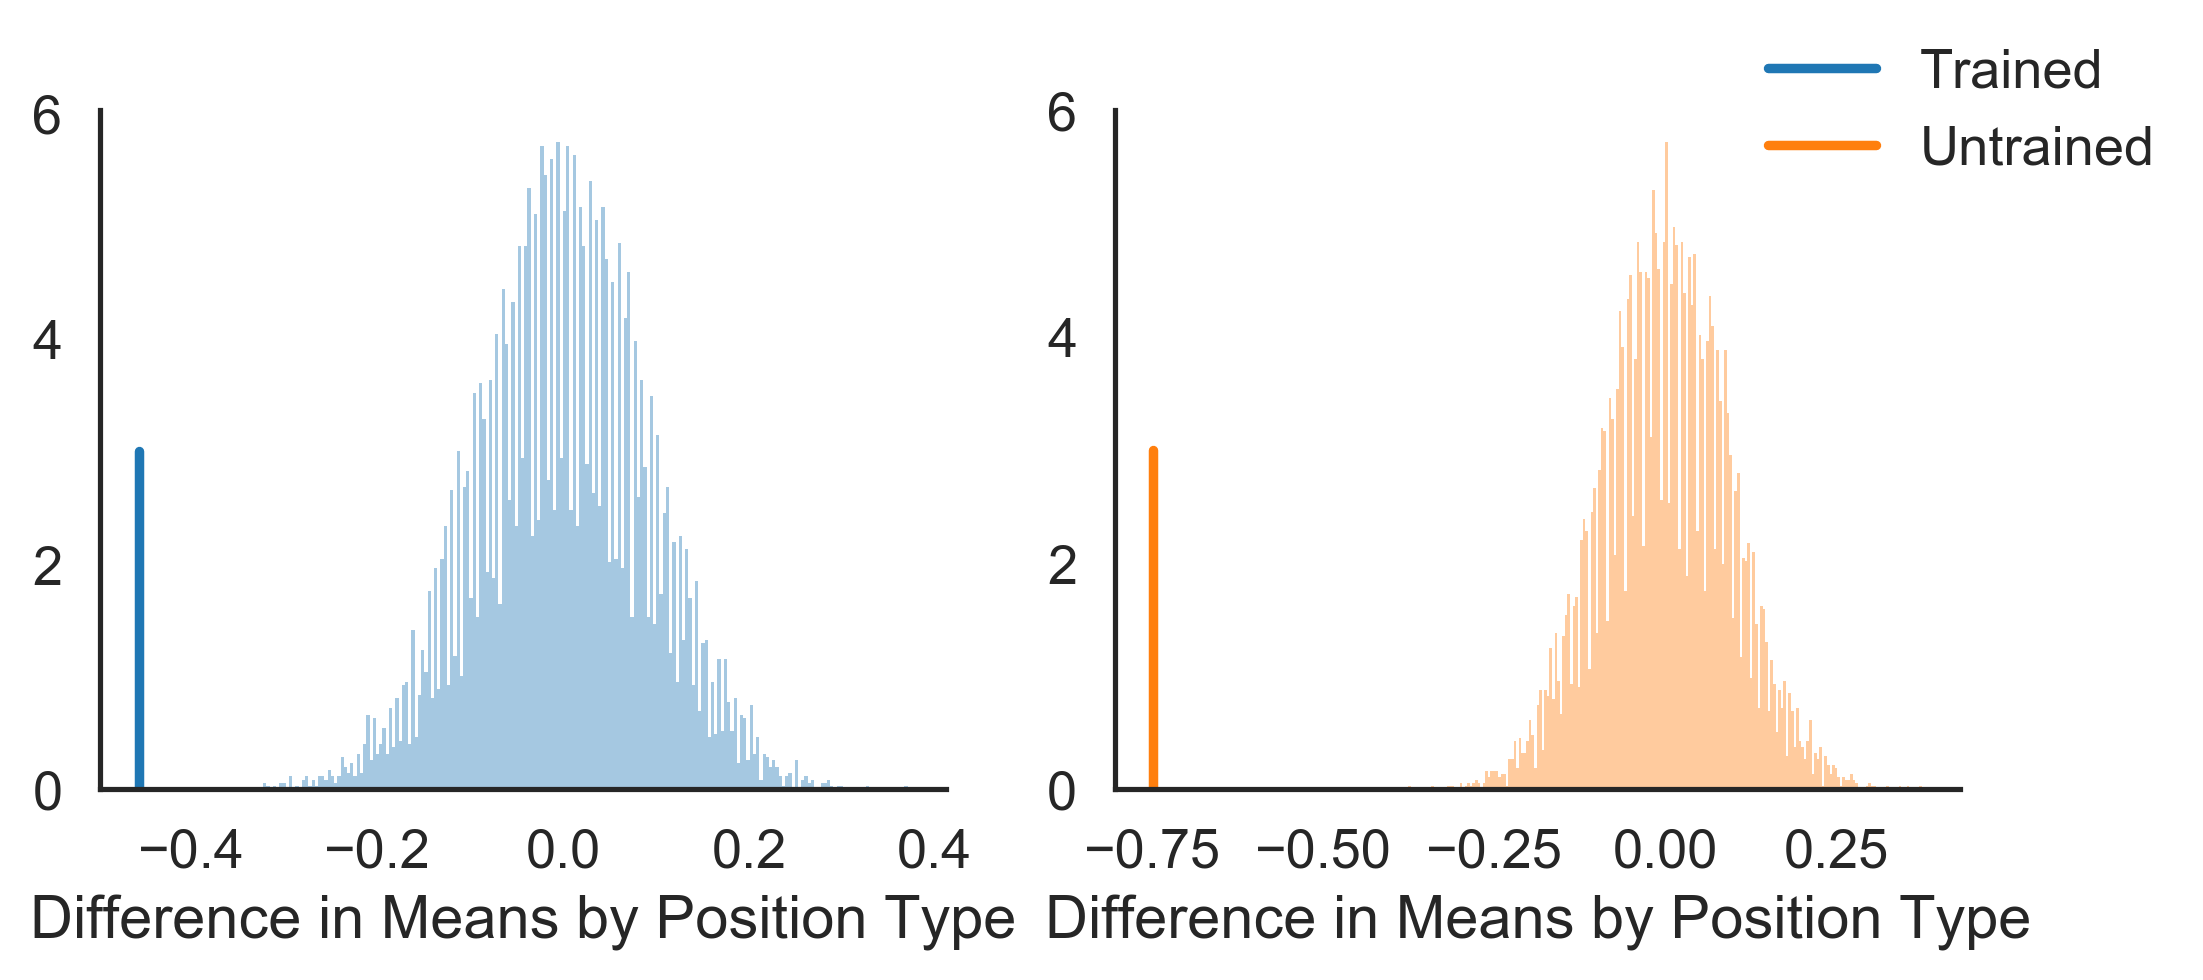

In [13]:
samples, axes = within_permutation_test('Num Dif')

In [ ]:
cpiv = tidy.pivot_table(
    index='Subject ID', values='Total Errors',
    columns='Is Real',
    aggfunc=np.mean
)

cpiv['Condition'] = cpiv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])

cpiv_filter = cpiv['Condition'] == 'Trained'
true_real_dif_x_group = cpiv.loc[cpiv_filter, True].mean() - cpiv.loc[~cpiv_filter, True].mean()
true_fake_dif_x_group = cpiv.loc[cpiv_filter, False].mean() - cpiv.loc[~cpiv_filter, False].mean()

true_trained_dif_x_type = cpiv.loc[cpiv_filter, True].mean() - cpiv.loc[cpiv_filter, False].mean()
true_untrained_dif_x_type = cpiv.loc[~cpiv_filter, True].mean() - cpiv.loc[~cpiv_filter, False].mean()

In [ ]:
resampled_trained = []
resampled_naive = []

g = tidy.groupby('Subject ID', sort=False)

for i in range(n_resamples):
    tidy['Is Real_R'] = pd.melt(
        pd.DataFrame(g.apply(lambda x: x[['Is Real', 'Subject ID']].sample(frac=1, replace=False))),
        id_vars=['Subject ID'], value_vars=['Is Real'], value_name='Is Real'
    )['Is Real'].values

    is_trained = tidy['Condition'] == 'Trained'
    is_real = tidy['Is Real_R']
    
    trained_dif = tidy.loc[is_trained & is_real, 'Total Errors'].mean() - tidy.loc[is_trained & ~is_real, 'Total Errors'].mean()
    naive_dif = tidy.loc[~is_trained & is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & ~is_real, 'Total Errors'].mean()

    resampled_trained.append(trained_dif)
    resampled_naive.append(naive_dif)

sns.distplot(resampled_trained, bins=200, norm_hist=True)
sns.distplot(resampled_naive, bins=200, norm_hist=True)

plt.plot([original_trained_dif, original_trained_dif], [0, 2.5])
plt.plot([original_naive_dif, original_naive_dif], [0, 2.5])

sns.despine()

resampled_trained = np.stack(resampled_trained)
true_loc = (resampled_trained >= np.abs(original_trained_dif))
true_loc |= (resampled_trained <= -np.abs(original_trained_dif))

len(resampled_trained[true_loc]) / len(resampled_trained)

In [ ]:
cpiv

In [ ]:
print(true_fake_dif_x_group, true_real_dif_x_group)

In [ ]:
print(true_trained_dif_x_type, true_untrained_dif_x_type)

In [ ]:
# Is there a significant difference between conditions?

num_resamples = 10000

resampled_real = []
resampled_fake = []

for i in range(num_resamples):
    
    cpiv['cr'] = cpiv['Condition'].sample(frac=1, replace=False).values
    cpiv_filter = cpiv['cr'] == 'Trained'
    
    real_dif_x_group = cpiv.loc[cpiv_filter, True].mean() - cpiv.loc[~cpiv_filter, True].mean()
    fake_dif_x_group = cpiv.loc[cpiv_filter, False].mean() - cpiv.loc[~cpiv_filter, False].mean()
    
    resampled_real.append(real_dif_x_group)
    resampled_fake.append(fake_dif_x_group)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
sns.distplot(resampled_real, color=colors[0], bins=200, kde=False, norm_hist=True, ax=axes[0])
sns.distplot(resampled_fake, bins=200, color=colors[1], kde=False, norm_hist=True, ax=axes[1])

axes[0].plot([true_real_dif_x_group, ]*2, [0, 1], color=colors[0], label='Real')
axes[1].plot([true_fake_dif_x_group, ]*2, [0, 1], color=colors[1], label='Fake')

plt.figlegend(loc=0)
plt.setp(axes, xlabel='Condition Mean Difference')

sns.despine()

In [ ]:
resampled_real = np.stack(resampled_real)
real_loc = (resampled_real >= np.abs(true_real_dif_x_group))
real_loc |= (resampled_real <= -np.abs(true_real_dif_x_group))

print('Real positions p:', len(resampled_real[real_loc]) / len(resampled_real))

resampled_fake = np.stack(resampled_fake)
fake_loc = (resampled_fake >= np.abs(true_fake_dif_x_group))
fake_loc |= (resampled_fake <= -np.abs(true_fake_dif_x_group))

print('Fake positions p:', len(resampled_fake[fake_loc]) / len(resampled_fake))


In [ ]:
position_map = tidy.pivot_table(
    index='Position ID', values='Is Real', aggfunc=lambda x: x.values[0]
)

# check to make sure position IDs cannot be reassigned to a position that might exist in both types
position_map['Resampled'] = position_map['Is Real'].sample(frac=1, replace=False).values

tidy['Resampled Real'] = tidy['Position ID'].map(position_map['Resampled'])

In [ ]:
num_resamples = 10000

resampled_trained = []
resampled_untrained = []

for i in range(num_resamples):
    position_map['Resampled'] = position_map['Is Real'].sample(frac=1, replace=False).values
    tidy['Resampled Real'] = tidy['Position ID'].map(position_map['Resampled']).values
    
    cpiv = tidy.pivot_table(
        index='Subject ID', values='Total Errors',
        columns='Resampled Real',
        aggfunc=np.mean
    )
    
    cpiv['Condition'] = cpiv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])

    cpiv_filter = cpiv['Condition'] == 'Trained'
    
    trained_dif_x_type = cpiv.loc[cpiv_filter, True].mean() - cpiv.loc[cpiv_filter, False].mean()
    untrained_dif_x_type = cpiv.loc[~cpiv_filter, True].mean() - cpiv.loc[~cpiv_filter, False].mean()
    
    resampled_trained.append(trained_dif_x_type)
    resampled_untrained.append(untrained_dif_x_type)
    

In [ ]:
resampled_trained = np.stack(resampled_trained)
resampled_untrained = np.stack(resampled_untrained)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
sns.distplot(resampled_trained, color=colors[2], bins=200, kde=False, norm_hist=True, ax=axes[0])
sns.distplot(resampled_untrained, bins=200, color=colors[4], kde=False, norm_hist=True, ax=axes[1])

axes[0].plot([true_trained_dif_x_type, ]*2, [0, 1], color=colors[2], label='Trained')
axes[1].plot([true_untrained_dif_x_type, ]*2, [0, 1], color=colors[4], label='Untrained')

plt.figlegend(loc=0)
plt.setp(axes, xlabel='Position Type Mean Difference')

sns.despine()

In [ ]:
trained_loc = (resampled_trained >= np.abs(true_trained_dif_x_type))
trained_loc |= (resampled_trained <= -np.abs(true_trained_dif_x_type))

print('Real positions p:', len(resampled_trained[trained_loc]) / len(resampled_trained))

resampled_untrained = np.stack(resampled_untrained)
untrained_loc = (resampled_untrained >= np.abs(true_untrained_dif_x_type))
untrained_loc |= (resampled_untrained <= -np.abs(true_untrained_dif_x_type))

print('Fake positions p:', len(resampled_untrained[untrained_loc]) / len(resampled_untrained))

In [ ]:

original_condition = tidy['Condition'].values
oritinal_real = tidy['Is Real'].values

is_trained = tidy['Condition'] == 'Trained'
is_real = tidy['Is Real']

# Difference between *condition* split by *is real*
original_true_dif = tidy.loc[is_trained & is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & is_real, 'Total Errors'].mean()
original_false_dif = tidy.loc[is_trained & ~is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & ~is_real, 'Total Errors'].mean()

# Difference between *is real* split by *condition*
original_trained_dif = tidy.loc[is_trained & is_real, 'Total Errors'].mean() - tidy.loc[is_trained & ~is_real, 'Total Errors'].mean()
original_naive_dif = tidy.loc[~is_trained & is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & ~is_real, 'Total Errors'].mean()

print(original_true_dif, original_false_dif)
print(original_trained_dif, original_naive_dif)

In [ ]:
n_resamples = 100000

resampled_true = []
resampled_false = []

for i in range(n_resamples):
    tidy['Condition_R'] = tidy['Condition'].sample(frac=1, replace=False).values
    is_trained = tidy['Condition_R'] == 'Trained'
    is_real = tidy['Is Real']
    
    true_dif = tidy.loc[is_trained & is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & is_real, 'Total Errors'].mean()
    false_dif = tidy.loc[is_trained & ~is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & ~is_real, 'Total Errors'].mean()
    
    resampled_true.append(true_dif)
    resampled_false.append(false_dif)

In [ ]:
# sorted_resampled_true = np.sort(resampled_true)
# plt.plot(sorted_resampled_true, linestyle='none', marker='o')
sns.distplot(resampled_true, bins=200, norm_hist=True)
sns.distplot(resampled_false, bins=200, norm_hist=True)

plt.plot([original_true_dif, original_true_dif], [0, 2.5])
plt.plot([original_false_dif, original_false_dif], [0, 2.5])

sns.despine()

In [ ]:
resampled_true = np.stack(resampled_true)
true_loc = (resampled_true >= np.abs(original_true_dif))
true_loc |= (resampled_true <= -np.abs(original_true_dif))

len(resampled_true[true_loc]) / len(resampled_true)